In [1]:
# PAIRWISE CLASSIFICATION EXAMPLE
# BFgam VS CMgam
# 28/07/2019
require(compiler)
require(MASS)
require(RcppNumerical)
setMKLthreads(20)
#setwd()

Loading required package: compiler
Loading required package: MASS
Loading required package: RcppNumerical


In [2]:
# FOR SIMPLICITY I JUST USE THE SAME SNPs AS IN THE 13-POPULATION CLASSIFICATION
load('Haplotype_16Filtered.RData')
ls()

[1] "haplotype" "label"     "POS"

In [3]:
# JUST SOME FUNCTIONS
fsum<-function(x) {.Primitive('sum')(x)}
gc2<-function() {invisible(gc())}

In [4]:
# CHOOSE THE TWO TARGETED POPULATIONS
pop1<-'BFgam'
pop2<-'CMgam'
haplotype1<-haplotype[label==pop1,]
haplotype2<-haplotype[label==pop2,]
dim(haplotype1)
dim(haplotype2)
rm(haplotype); gc2(); 

[1]    184 117461

[1]    594 117461

In [5]:
# FILTER MAF ON THE COMBINED POPULATION. RETAIN THE ALLELE FREQ (freq) VECTOR
mode(haplotype1)<-'numeric'
mode(haplotype2)<-'numeric'
freq<-apply(rbind(haplotype1, haplotype2), 2, fsum)/(nrow(haplotype1)+nrow(haplotype2))
maf<-freq
maf[maf>0.5]<-1-maf[maf>0.5]

In [6]:
# SELECT LOCI WITH MAF>5%?
s<-(maf>=0.05)
sum(s)
#plot(maf1, maf2)
haplotype1<-haplotype1[,s]
haplotype2<-haplotype2[,s]
freq<-freq[s]
POS<-POS[s]
dim(haplotype1)
dim(haplotype2)
length(POS)
rm(maf); rm(s); gc2(); 
# 107195 LOCI REMAINING

[1] 107195

[1]    184 107195

[1]    594 107195

[1] 107195

In [7]:
# I DON'T THINK I NEED ANOTHER ROUND OF LD PRUNNING. 
# NOW LOOK AT PRIVATE ALLELES OUT OF THESE 107195 LOCI?
freq1<-apply(haplotype1, 2, fsum)/nrow(haplotype1)
freq2<-apply(haplotype2, 2, fsum)/nrow(haplotype2)

sum(freq1==0 & freq2>0)
sum(freq1==1 & freq1<1)
sum(freq2==0 & freq1>0)
sum(freq2==1 & freq1<1)
rm(freq1); rm(freq2); gc2(); 
# SO THE CONCLUSION IS THAT THERE AREN'T TOO MANY PRIVATE ALLELES IN THIS EXAMPLE

[1] 1

[1] 0

[1] 0

[1] 0

In [8]:
# CREATE GENOTYPE DATASETS AND POPULATION LABELS
odd<-seq(1, nrow(haplotype1), 2)
even<-seq(2, nrow(haplotype1), 2)
genotype1<-haplotype1[odd,]+haplotype1[even,]
rm(odd); rm(even);
odd<-seq(1, nrow(haplotype2), 2)
even<-seq(2, nrow(haplotype2), 2)
genotype2<-haplotype2[odd,]+haplotype2[even,]
rm(odd); rm(even);
dim(genotype1)
dim(genotype2)
genotype_both<-rbind(genotype1, genotype2)
label1<-rep(pop1, nrow(genotype1))
label2<-rep(pop2, nrow(genotype2))
label_both<-c(label1, label2)
col1<-rep(1, nrow(genotype1))
col2<-rep(2, nrow(genotype2))
col_both<-c(col1, col2)
rm(haplotype1); rm(haplotype2); gc2();

[1]     92 107195

[1]    297 107195

In [9]:
# SUPERVISED LEARNING
# THE PLAN IS USE LOGISTIC REGRESSION AS THE CLASSIFIER
# BUT THE FIRST STEP IS ALWATS TO SPLIT INTO TRAINING AND TESTING SET. 80:20, STRATIFIED. 
set.seed(12345)
s<-sample(nrow(genotype1), size=round(0.8*nrow(genotype1)))
train_genotype1<-genotype1[s,]
test_genotype1<-genotype1[-s,]
train_label1<-label1[s]
test_label1<-label1[-s]
train_col1<-col1[s]
test_col1<-col1[-s]
rm(s)
s<-sample(nrow(genotype2), size=round(0.8*nrow(genotype2)))
train_genotype2<-genotype2[s,]
test_genotype2<-genotype2[-s,]
train_label2<-label2[s]
test_label2<-label2[-s]
train_col2<-col2[s]
test_col2<-col2[-s]
rm(s)
# COMBINE THE TWO POPULATIONS
train_genotype<-rbind(train_genotype1, train_genotype2)
train_label<-c(train_label1, train_label2)
train_col<-c(train_col1, train_col2)
test_genotype<-rbind(test_genotype1, test_genotype2)
test_label<-c(test_label1, test_label2)
test_col<-c(test_col1, test_col2)
# y IS THE NUMERIC VERSION OF train_label. 0=pop1, 1=pop2
y<-as.numeric(train_label==pop2)

In [10]:
# CHECK DIMINSIONS (OPTIONAL, JUST FOR ERROR CHECKING)
#dim(train_genotype)
#length(train_label)
#length(train_col)
#dim(test_genotype)
#length(test_label)
#length(test_col)

In [11]:
# 1) LOGISTIC REGRESSION ON THE RAW GENOTYPE. WILL IT WORK?
#m<-glm(train_label~train_genotype, family='binomial')

In [12]:
# THE PLAIN VANILLA glm() IS TOO SLOW
# TRY USING fastLR() FROM RcppNumerical PACKAGE

system.time(m<-fastLR(y=y, x=train_genotype, maxit=1000))
# THE MAXIMISED LOG-LIKELIHOOD VALUE
m$loglikelihood

   user  system elapsed 
   3.78    0.00    3.79 

[1] -6.545997e-08

In [35]:
# TO SEE THE FITTED VALUES OF THE TRAIN SET
# temp IS THE LINEAR PREDICTOR. IF temp<0 IT IS pop1=BFgam
temp<-train_genotype%*%m$coefficients
data.frame(linear_predictor=temp, train_label=train_label)

linear_predictor,train_label
-26.22508,BFgam
-29.29594,BFgam
-32.55754,BFgam
-28.51164,BFgam
-23.74435,BFgam
-22.53583,BFgam
-25.79279,BFgam
-28.41861,BFgam
-22.87849,BFgam
-27.42624,BFgam


In [36]:
# HOW ABOUT FITTING TO THE TEST SET?
# IT DOESN'T SEEM TO WORK AT ALL
# OVERFITTING???
temp<-test_genotype%*%m$coefficients
data.frame(linear_predictor=temp, test_label=test_label)

linear_predictor,test_label
-0.3843686,BFgam
-0.2984299,BFgam
6.9381474,BFgam
5.8193715,BFgam
-2.0617227,BFgam
5.5302051,BFgam
4.2745577,BFgam
1.6610976,BFgam
4.9677042,BFgam
7.5921681,BFgam


In [37]:
# TEST SET PREDICTION
test_predict<-ifelse(temp<0, pop1, pop2)
sum(test_predict==test_label)/length(test_predict)

[1] 0.8181818

IGNORE THE THINGS BELOW
29/07/2019

I think I ran into the problem of overfitting. The fitted values of the training set is perfect. But when I apply the trained logistic model to the testing set, it doesn't work at all. 


POS,coef
30043067,-0.03593741
30041338,-0.03566259
28241498,-0.03400762
29309533,-0.03319328
31736265,0.03296181
6880356,-0.03142650
27264636,0.03101824
31628425,0.03091367
28630086,-0.03090610
27121724,-0.03039591


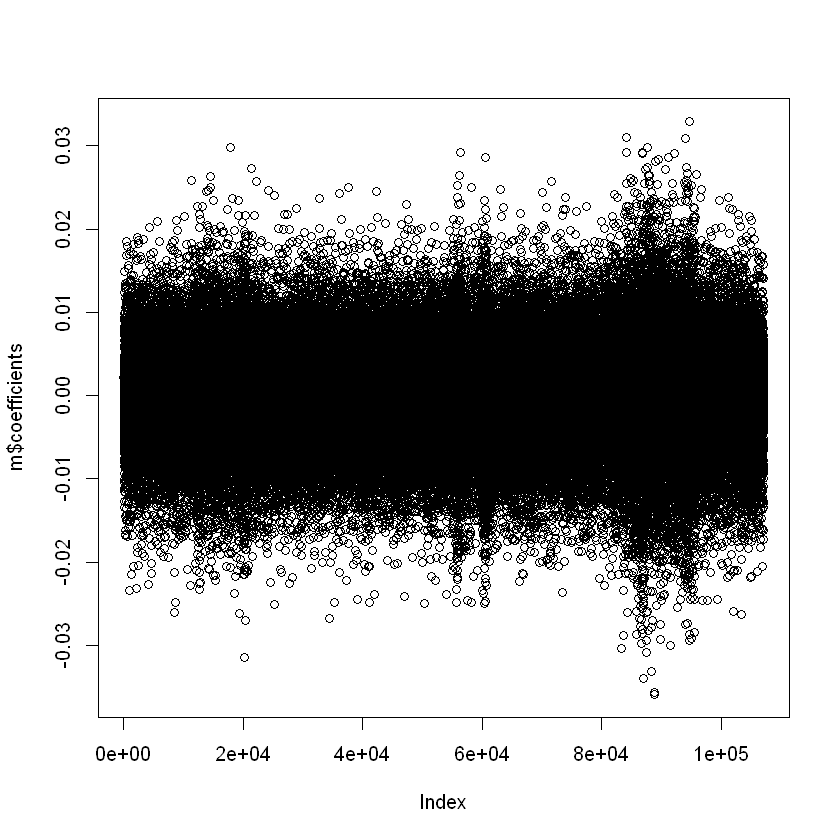

In [15]:
# SNPs CONTRIBUTION?
plot(m$coefficients)
contribution_order<-order(abs(m$coefficients), decreasing=T)
data.frame(POS=POS[contribution_order[1:10]], coef=m$coefficients[contribution_order[1:10]])

In [16]:
# THE PLAIN VANILLA glm() IS TOO SLOW
# TRY WRITING MY OWN LOGISTIC LOG-LIKELIHOOD FUNCTION INVERSE
# RETURNING 1/LOG_LIKE. THEN MINIMISE IT. 
# parm IS A VECTOR OF PARAMETERS WITH LENGTH EQUALS LOCI NUMBER
# y IS THE RESPONSE, OR THE CLASS LABELS (VECTOR), 0=pop1, 1=pop2
y<-as.numeric(train_label==pop2)
log.like.inv<-function(parms)
{
    temp<-train_genotype%*%parms
    temp1<-exp(temp)
    p<-temp1/(1+temp1)
    l<-y*log(p)+(1-y)*log(1-p)
    # REMOVE TOO SMALL PROB
    l2<-l[!is.na(l)]
    return(1/fsum(l2))
}
log.like.inv<-cmpfun(log.like.inv)

# TRY 
log.like.inv(rep(0, length(POS)))
system.time(log.like.inv(rep(0, length(POS))))
# ELAPSE TIME 0.06, TOTAL CPU TIME 1.25s ACROSS 20 CORES. PERFECT SCALING...?
# THE EVALUATION OF THE LOG-LIKE INVOLVES A MATRIX MULTIPLICATION. 
# A GOOD LINPACK DOES THE JOB

[1] -0.004624023

   user  system elapsed 
   1.25    0.00    0.06 

In [17]:
# IF WE EVALUATE THE FUNCTION AT THE SAME POINT WE SHOULD GET THE SAME LOG-LIKE VALUE
1/log.like.inv(m$coefficients)
# YAY!!!

[1] -6.546205e-08

In [18]:
# TO AVOID OVERFITTING I NOW USE PCA AS A DATA REDUCTION TOOL
# FIRST APPLY PATTERSON'S NORMALISATION
train_freq<-apply(train_genotype, 2, fsum)/(2*nrow(train_genotype))
train_freq2<-matrix(train_freq, ncol=ncol(train_genotype), nrow=nrow(train_genotype), byrow=T)
normal_train_genotype<-(train_genotype-2*train_freq2)/sqrt(train_freq2*(1-train_freq2))
rm(train_freq2); gc2(); 

In [19]:
# PCA VIA prcomp(). USE FIRST n COMPONENTS
system.time(e<-prcomp(normal_train_genotype))
n<-100
train_feature<-normal_train_genotype%*%e$rotation[,1:n]
dim(train_feature)

   user  system elapsed 
  24.83    0.97    3.04 

[1] 312 100

In [20]:
# RUN A LOGISTIC REGRESSION. NO INTERCEPT
# OFTEN WE NEED TO PUT THINGS IN A data.frame
train_df<-data.frame(train_label=train_label, train_feature=train_feature)
m2<-glm(train_label~.-1, data=train_df, family='binomial')

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [21]:
# SADLY NONE OF THE PCs IS STATISTICALLY SIGNIFICANT
# PATTERSON TRANSFORM THE TEST SET, AND CREATE TEST FEATURES
test_freq2<-matrix(train_freq, nc=ncol(test_genotype), nr=nrow(test_genotype), byrow=T)
normal_test_genotype<-(test_genotype-2*test_freq2)/sqrt(test_freq2*(1-test_freq2))
test_feature<-normal_test_genotype%*%e$rotation[,1:n]
dim(test_feature)
rm(train_freq); rm(test_freq2); invisible(gc());

[1]  77 100

In [22]:
# FIT TO THE TEST SET
test_df<-data.frame(test_feature=test_feature)
names(test_df)<-names(train_df)[-1]
test_predict<-predict(m2, test_df, type='response')
test_predict<-ifelse(test_predict<0.5, pop1, pop2)
# ACCURACY
sum(test_predict==test_label)/length(test_predict)

[1] 0.8961039

In [23]:
# NOW TRY LDA. WE EXPECT LDA IS WORSE THAN LOGISTIC WITH ONLY TWO CATEGORIES
m3<-lda(train_feature, grouping=train_label, prior=c(0.5,0.5))
test_predict2<-predict(m3, test_feature, type='class')$class
test_predict2<-as.character(test_predict2)
# ACCURACY
sum(test_predict2==test_label)/length(test_predict)

[1] 0.7792208